## Analyzing Chinook Database

Chinook is a sample database available for SQL Server, Oracle, MySQL, etc. It can be created by running a single SQL script. Chinook database is an alternative to the Northwind database, being ideal for demos and testing ORM tools targeting single and multiple database servers.

For the purpose of this project, we will be using this dataset to answer to some business questions:

 1- Which Genres sell the best in the U.S.A?
 
 2- Which 3 of the following genres and artists should be sold in the USA?
    - Hip-Hop : Regal
    - Punk : Red Tone
    - Pop: Meteor and the Girls
    - Blues: Slim Jim Bites
 3- Which Sales aupport agent is performing better or worse than others?
 
 4- Which countries had the highest total spent?

5- what percentage of purchases are individual tracks vs whole albums

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
os.listdir()

['chinook.db',
 '.ipynb_checkpoints',
 'chinook-unmodified.db',
 'chinbook.db',
 'Chinook Analysis.ipynb']

## Helper functions

In [3]:
db = 'chinook.db'

q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
def run_query(q):
    #takes a SQL query as an argument
    #returns a pandas dataframe of that query
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    #takes a SQL command as an argument 
    #executes it using the sqlite module
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    #returns a list of all tables ad views in the database
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase

In this part, we want to determine which genres sell the best in the USA. We first need to take a look at the tables to understand how the relationships between the tables help us to answer to this question.

In [4]:
genre_table = 'SELECT * FROM genre LIMIT 5'
run_query(genre_table)

,genre_id,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll


In [5]:
track_table = 'SELECT * FROM track LIMIT 5'
run_query(track_table)

,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


In [6]:
invoice_line_table = 'SELECT * FROM invoice_line LIMIT 5'
run_query(invoice_line_table)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1


In [7]:
invoice_table = 'SELECT * FROM invoice LIMIT 5'
run_query(invoice_table)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83


In [8]:
customer_table = 'SELECT * FROM customer LIMIT 5'
run_query(customer_table)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


The table that we want to create includes each genre, and number of tracks sold in absolute number and percentages.

We are going to use the tables shown above to create our final table. The first thing we need to do is to create a subquery which return the number of tracks sold in the USA and then use than to find the number of genres.

In [46]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    JOIN invoice i 
    ON il.invoice_id = i.invoice_id
    JOIN customer c 
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
JOIN track t 
ON t.track_id = uts.track_id
JOIN genre g
ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


As shown in the table above, the three most popular genres are Rock, Alternative & Punk and Metal.

Let's create a bar graph to make easier to compare the genres.

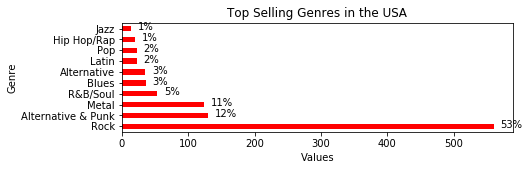

In [47]:
from matplotlib.pyplot import figure
figure(num = None, figsize = (7, 2))

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre', inplace = True, drop = True)

genre_sales_usa['tracks_sold'].plot.barh(
                                        title = 'Top Selling Genres in the USA',
                                        color = 'red')
#plt.xlim(0, 700)
plt.ylabel('Genre')
plt.xlabel('Values')
#Let's show the percentages on top of the bars
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.savefig('top_selling_genres.png')
plt.show()


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

For this part, we are going to analyze the purchases of the customers belonging to each employee to see if any sales support agent performed either better or worse that the others.

Therefore, we are going to need to obtain three columns which would explain the employee name, hire date and total sales.

In [48]:
employee_table = 'SELECT * FROM employee LIMIT 5'
run_query(employee_table)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [49]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
    SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) AS total
    FROM invoice i 
    JOIN customer c
    ON i.customer_id = c.customer_id
    GROUP BY 1, 2
    )
    
SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrc.total) total_sales
FROM customer_support_rep_sales csrc
JOIN employee e
ON csrc.support_rep_id = e.employee_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


Now that we know which employee had the highest total sales, let's create a bar graph to make it visually appealing.

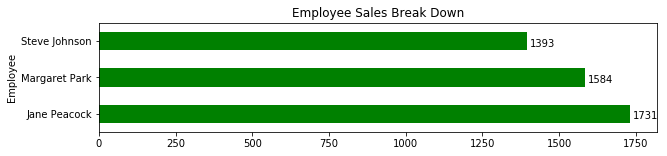

In [50]:
from matplotlib.pyplot import figure
figure(num = None, figsize = (10, 2))

employee_sales = run_query(employee_sales_performance)
employee_sales.set_index('employee', inplace = True, drop = True)

employee_sales['total_sales'].plot.barh(
                                        title = 'Employee Sales Break Down',
                                        color = 'green'
                                        )
#plt.xlim(0, 700)
plt.ylabel('Employee')

#Let's show the total on top of the bars
for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total_sales"]
    label = (employee_sales.loc[label, "total_sales"]
            ).astype(int).astype(str) 
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.savefig('employee_sales_breakdown.png')
plt.show()

We can now see that Jane Peacock had the highest sales.

One more thing to notice is their higher rate. We usually expect the employees who were hired earlier to have the most number sales. In this case, Jane Peacock was hired 2017-04 which was earlier than the other employees. Therefore, it is not a surprise that she had the highest total sales.

## Analyzing Sales by Country

We need to analyze the sales data for customers from each different country and calculate data, for each country, on the:

1- Total number of customers

2- Total Values of sales

3- Average value of sales per customer

4- average order value

Since there are some countries where they had only 1 customer, we are going to group them together.

In [51]:
sales_by_country = '''
WITH country_or_other AS
     (
        SELECT
        CASE
            WHEN (
                 SELECT count(*)
                 FROM customer
                    where country = c.country
                ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
     )
     

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
(
    SELECT 
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        ROUND(SUM(unit_price) / COUNT(DISTINCT customer_id),2) customer_lifetime_value,
        ROUND(SUM(unit_price) / COUNT(DISTINCT invoice_id),2) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM country_or_other
    GROUP BY 1
    ORDER BY 3 DESC
);
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,Other,15,1094.94,7.45,73.00
1,USA,13,1040.49,7.94,80.04
2,Canada,8,535.59,7.05,66.95
3,Brazil,5,427.68,7.01,85.54
4,France,5,389.07,7.78,77.81
5,Germany,4,334.62,8.16,83.66
6,Czech Republic,2,273.24,9.11,136.62
7,United Kingdom,3,245.52,8.77,81.84
8,Portugal,2,185.13,6.38,92.57
9,India,2,183.15,8.72,91.58


Again, let's make some cool visualizations based on the these data!

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


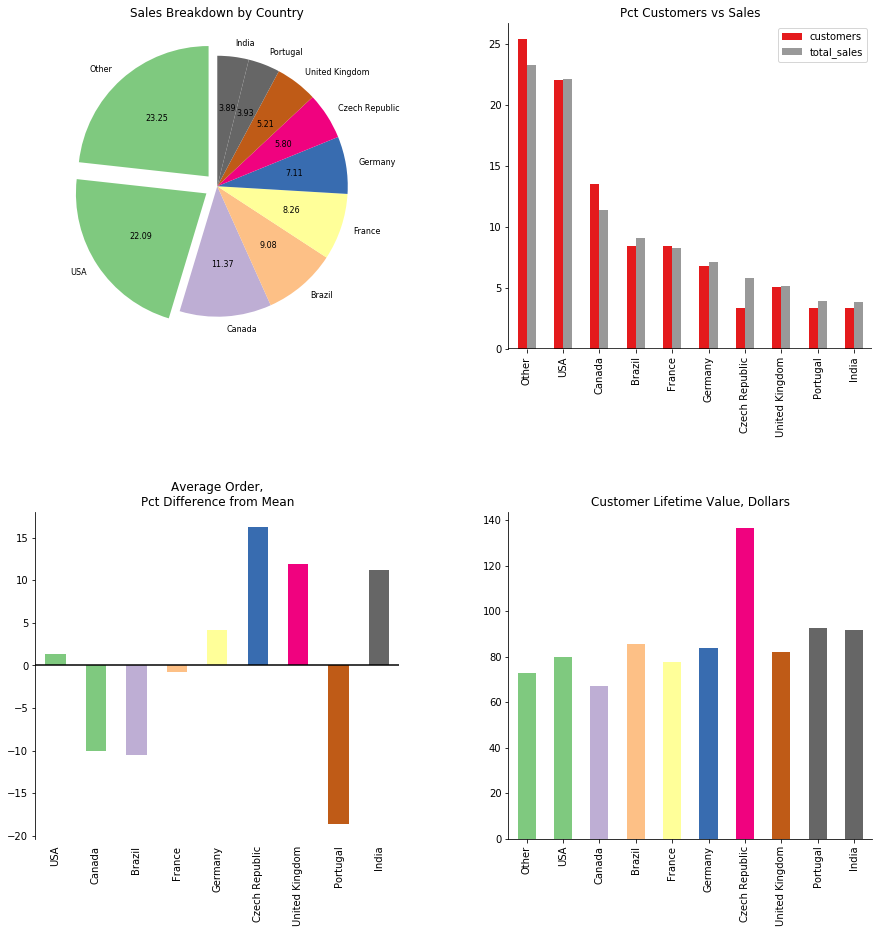

In [52]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country', inplace = True, drop = True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]


fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
ax1, ax2, ax3, ax4 = axes.flatten() #used flatten to unpack the subplots automatically
fig.subplots_adjust(hspace=.5, wspace=.3) #to make distance between the plots to make it visually appealing

#top_left
explode = (0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
sales_breakdown = country_metrics['total_sales'].copy().rename('') #to remove the 'total sales' from the y axis
sales_breakdown.plot.pie(ax = ax1,
                        autopct = '%1.2f',
                        explode = explode,
                        startangle = 90,
                        counterclock = True,
                        title = 'Sales Breakdown by Country',
                        colormap = plt.cm.Accent,
                        fontsize = 8,
                        wedgeprops = {'linewidth':0})


#top_right
columns = ['customers', 'total_sales']
p = country_metrics[columns].copy()
p.index.name = ''
for c in columns:
    p[c] /= p[c].sum() / 100
p.plot.bar(ax = ax2,
          colormap=plt.cm.Set1,
         title="Pct Customers vs Sales")
ax2.axhline(0, color='k')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

#bottom_left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100  / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax = ax3,
    color = colors,
    title = "Average Order,\nPct Difference from Mean"
)
ax3.tick_params(bottom = "off")
ax3.axhline(0, color = 'k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#bottom_right
c_lifetime = country_metrics["customer_lifetime_value"].copy()
c_lifetime.index.name = ''
c_lifetime.plot.bar(
    ax = ax4,
    color = colors,
    title = "Customer Lifetime Value, Dollars"
)
#ax4.tick_params(top = "off", right = "off", left = "off", bottom = "off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.savefig('country_metrics.png')
plt.show()

## Albums vs Individual Tracks

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [54]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    (CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice) * 100
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.